# Disneyland Review Analysis

In [26]:
# Import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
# Load and view Disneyland Reviews dataset
reviews = pd.read_csv('DisneylandReviews.csv', encoding='ISO-8859-1')
reviews.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


# Exploratory Data Analysis

In [3]:
# Closer look at Rating and Branch variables
print(reviews.Rating.unique())
print(reviews.Branch.unique())

[4 3 5 2 1]
['Disneyland_HongKong' 'Disneyland_California' 'Disneyland_Paris']


In [4]:
# Remove any duplicate reviews
reviews.drop_duplicates(subset='Review_Text', keep='first', inplace=True, ignore_index=True)

In [5]:
# Overall rating for the three parks
print(reviews.Rating.mean())

4.217653405892287


In [6]:
# Create a Sentiment variable: reviews with ratings 4 and above = positive and 3 and below = negative.
sentiment = []
for rating in reviews.Rating:
    if rating >= 4:
        sentiment.append('positive')
    else: 
        sentiment.append('negative')
reviews['Sentiment'] = sentiment

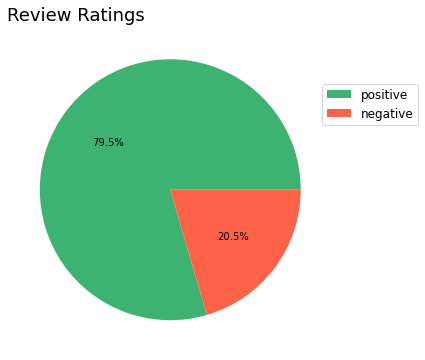

In [7]:
# Create pie chart to view the percentage of positive and negative reviews
data = reviews.groupby('Sentiment')['Review_Text'].count().nlargest()
pie, ax = plt.subplots(figsize=[6, 6])
labels = data.keys()
plt.pie(data.values, autopct='%1.1f%%', labels=None, colors=['mediumseagreen', 'tomato'])
plt.title('Review Ratings', fontsize=18, loc='left')
plt.legend(labels, bbox_to_anchor=(1.1,0.7), loc="center right", fontsize=12, bbox_transform=plt.gcf().transFigure)
plt.show()

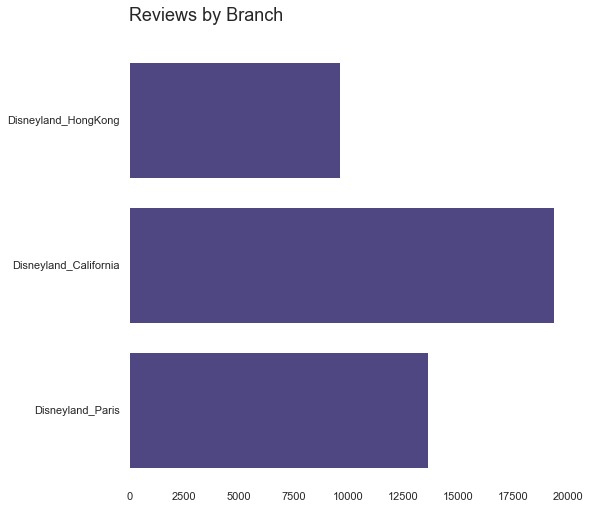

In [8]:
# Look at reviews by park
sns.set(font_scale=1.5)
sns.set(rc={'figure.figsize':(8, 8)})
sns.set_theme(style='white')
sns.countplot(data=reviews, y='Branch', color='darkslateblue')
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Reviews by Branch\n', size=18, loc='left')
plt.xlabel('', size=14)
plt.ylabel('', size=14)
for pos in ['right', 'top', 'left', 'bottom']:
     plt.gca().spines[pos].set_visible(False)
plt.show()

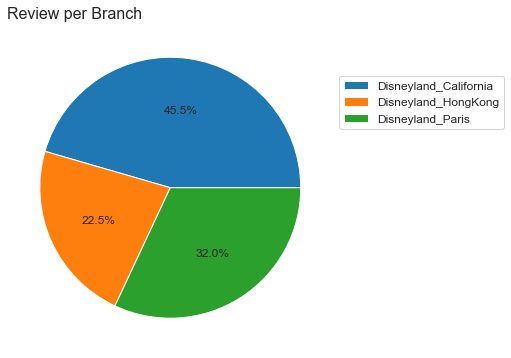

In [9]:
# There are more reviews for Disneyland, followed by Disneyland Paris and then Hong Kong Disneyland. 
data = reviews.groupby('Branch')['Review_Text'].count()
pie, ax = plt.subplots(figsize=[6, 6])
labels = data.keys()
plt.pie(data.values, autopct='%1.1f%%', labels=None, colors=['tab:blue', 'tab:orange', 'tab:green'])
plt.title('Review per Branch', fontsize=16, loc='left')
plt.legend(labels, bbox_to_anchor=(1.3,0.7), loc="center right", fontsize=12,
bbox_transform=plt.gcf().transFigure)
plt.show()

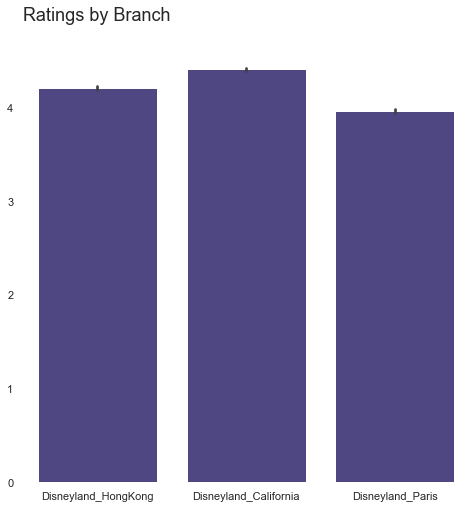

In [10]:
# View ratings per park
sns.set(font_scale=1.5)
sns.set(rc={'figure.figsize':(8, 8)})
sns.set_theme(style='white')
sns.barplot(data=reviews, y='Rating', x='Branch', color='darkslateblue')
plt.title('Ratings by Branch\n', size=18, loc='left')
plt.xlabel('', size=14)
plt.ylabel('', size=14)
for pos in ['right', 'top', 'left', 'bottom']:
     plt.gca().spines[pos].set_visible(False)
plt.show()

In [11]:
# View the average rating of each
reviews.groupby(['Branch'])['Rating'].mean()

Branch
Disneyland_California    4.405227
Disneyland_HongKong      4.204247
Disneyland_Paris         3.960079
Name: Rating, dtype: float64

# Data Preparation

In [12]:
# Functions to preprocess review text: convert to lowercase, remove punctuation, remove stops words, and lemmatize
def lower_nopunc(words):
    clean = re.sub(r'['+string.punctuation + '’—”'+']', '', words.lower())
    return re.sub(r'\W+', ' ', clean)

stop_words = stopwords.words('english')
def remove_stops(words):
    return ' '.join([word for word in words.split() if word not in stop_words])

lemmatizer = WordNetLemmatizer()
def lemmatize(words):
    return ' '.join([lemmatizer.lemmatize(word, pos='n') for word in words.split()])

reviews['clean1'] = reviews.Review_Text.map(lambda x: lower_nopunc(x))
reviews['clean2'] = reviews.clean1.apply(lambda x: remove_stops(x))
reviews['clean'] = reviews.clean2.map(lambda x: lemmatize(x))
print('clean text:  ', reviews['clean'].head())

clean text:   0    youve ever disneyland anywhere youll find disn...
1    since last time visit hk disneyland yet time s...
2    thanks god hot humid visiting park otherwise w...
3    hk disneyland great compact park unfortunately...
4    location city took around 1 hour kowlon kid li...
Name: clean, dtype: object


In [13]:
# Analysis Functions

# Function to return the top k words and plot
def get_top_k_words(k_top_words, count_vectorizer, text_data):
    vectorized_reviews = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_reviews, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((k_top_words, vectorized_reviews.shape[1]))
    for i in range(k_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:k_top_words].tolist()[0])


# Plot top n words for reviews
def plot_top_words(k, sentimentpark):
    sns.set(font_scale=1.5)
    sns.set_style(style='white')
    sns.barplot(x=word_values, y=words, color='steelblue')
    plt.title('Top {} words in {} reviews'.format(k, sentimentpark), loc='left')
    plt.xlabel('frequency', size=16)
    for pos in ['right', 'left', 'top', 'bottom']:
        plt.gca().spines[pos].set_visible(False)
    plt.show()
    
# Function to gather words for word cloud  
def word_cloud(text_data, color):
    words = ''
    for val in text_data:
        words += ''.join(val)
    wordcloud = WordCloud(width = 1600, height = 400,
                          background_color ='white',
                          stopwords = stops,
                          min_font_size = 12, 
                          colormap=color).generate(words)

    plt.figure(figsize = (16, 4), facecolor = None)
    ax.set_ylim(0.0, 50.0) # added see if works
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad = 0)
  
    plt.show()

In [14]:
text_data = reviews.clean

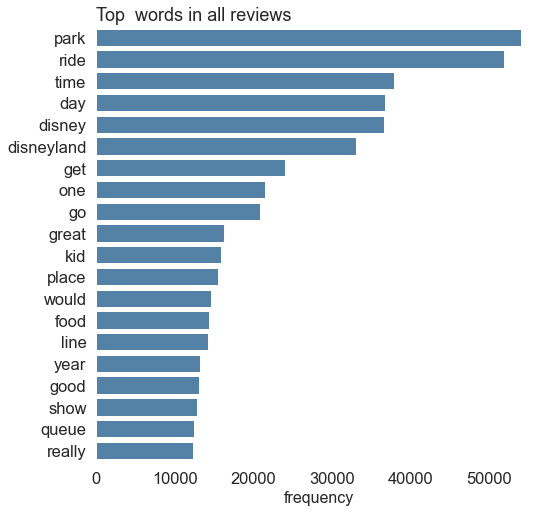

In [15]:
count_vectorizer = CountVectorizer()#stop_words=stops)
words, word_values = get_top_k_words(20, count_vectorizer, text_data)
plot_top_words('','all')

In [16]:
# I want to include the following words as stop words
stops = ['park', 'ride', 'time', 'day', 'disney', 'disneyland', 'get', 'go', 'one', 'place', 'kid', 
         'food', 'line', 'good', 'would', 'year', 'hong', 'kong', 'paris', 'california', 'adventure',
         'also']

In [17]:
pos_reviews = reviews[reviews.Sentiment=='positive'].reset_index()
neg_reviews = reviews[reviews.Sentiment=='negative'].reset_index()

In [18]:
# Topic Modeling Functions

# Function to return list of predicted topic categories for a given topic matrix
def get_keys(topic_matrix):
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

# Function to return tuple of topic categories and accompanying magnitudes for given list of keys
def keys_to_counts(keys):
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

# Function to return list of n_topic strings, where each string contains the n most common word in the predicted category
def get_top_n_words(n, keys, word_matrix, count_vectorizer):
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += word_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1, word_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

# LSA Functions

# Return n_topics with n number of word
def LSA(n_topics, word_matrix, n, count_vectorizer, m):
    lsa_model = TruncatedSVD(n_topics, random_state=0)
    lsa_topic_matrix = lsa_model.fit_transform(word_matrix)
    lsa_keys = get_keys(lsa_topic_matrix)
    lsa_categories, lsa_counts = keys_to_counts(lsa_keys)
    top_n_words_lsa = get_top_n_words(n, lsa_keys, word_matrix, count_vectorizer)
    for i in range(len(top_n_words_lsa)):
        print('Topic {}: '.format(i+1), top_n_words_lsa[i])
    
    # Plot top m words
    top_m_words = get_top_n_words(m, lsa_keys, word_matrix, count_vectorizer)
    lsa_categories.sort()
    labels = ['Topic {}: \n'.format(i+1) + top_m_words[i] for i in lsa_categories]
    sns.set(font_scale=1.5)
    sns.set_style(style='white')
    sns.barplot(x=lsa_counts, y=labels, color='steelblue')
    plt.title('LSA Topic Counts', loc='left')
    plt.xlabel('frequency', size=16)
    for pos in ['right', 'left', 'top', 'bottom']:
        plt.gca().spines[pos].set_visible(False)
    plt.show()

    
# LDA Functions

# Return n_topics with n number of words and plot top m words
def LDA(n_topics, word_matrix, n, count_vectorizer, m):
    lda_model = LatentDirichletAllocation(n_topics, 
                                          learning_method='online', 
                                          random_state=0)
    lda_topic_matrix = lda_model.fit_transform(word_matrix)

    lda_keys = get_keys(lda_topic_matrix)
    lda_categories, lda_counts = keys_to_counts(lda_keys)

    top_n_words_lda = get_top_n_words(n, lda_keys, word_matrix, count_vectorizer)

    for i in range(len(top_n_words_lda)):
        print("Topic {}: ".format(i+1), top_n_words_lda[i])

    # Plot top m words of each topic
    top_m_words = get_top_n_words(m, lda_keys, word_matrix, count_vectorizer)
    lda_categories.sort()
    labels = ['Topic {}: \n'.format(i+1) + top_m_words[i] for i in lda_categories]
    sns.set(font_scale=1.5)
    sns.set_style(style='white')
    sns.barplot(x=lda_counts, y=labels, color='steelblue')
    plt.title('LDA Topic Counts', loc='left')
    plt.xlabel('frequency', size=16)
    for pos in ['right', 'left', 'top', 'bottom']:
        plt.gca().spines[pos].set_visible(False)
    plt.show()

In [19]:
# I want to look at each park separately 
ca_reviews = reviews[reviews.Branch=='Disneyland_California'].reset_index()
hk_reviews = reviews[reviews.Branch=='Disneyland_HongKong'].reset_index()
p_reviews = reviews[reviews.Branch=='Disneyland_Paris'].reset_index()

# Disneyland

In [20]:
# First, I will look at Disneyland in California
pos_ca = ca_reviews[ca_reviews.Sentiment=='positive'].reset_index()
neg_ca = ca_reviews[ca_reviews.Sentiment=='negative'].reset_index()

## Positive Reviews

In [21]:
text_data = pos_ca.clean

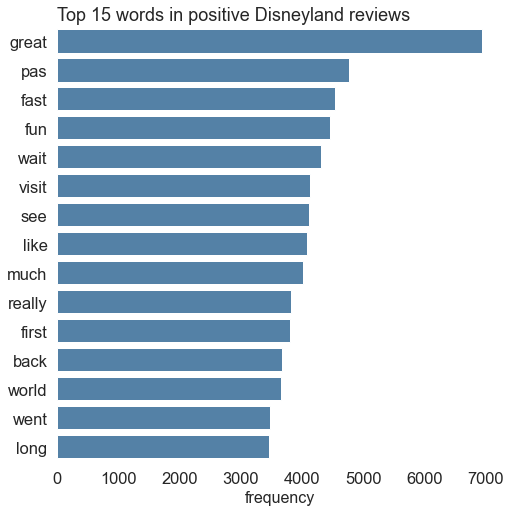

In [22]:
count_vectorizer = CountVectorizer(stop_words=stops)
words, word_values = get_top_k_words(15, count_vectorizer, text_data)
plot_top_words(15, 'positive Disneyland')

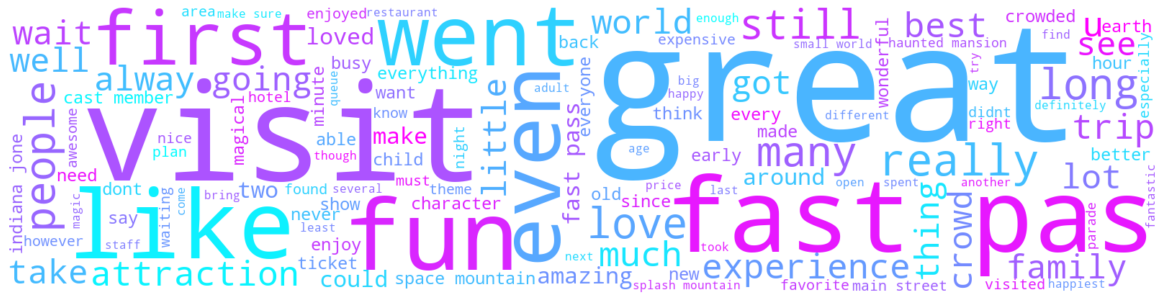

In [23]:
word_cloud(text_data, 'cool')

In [24]:
#word_cloud(text_data, 'winter')

### Topic Modeling

#### Latent Semantic Analysis (LSA)

Topic 1:  great fun wait see pas visit like much fast really
Topic 2:  fast pas pass use wait ticket long early great hour
Topic 3:  ticket bag per dl busy hour map want fastpass voucher
Topic 4:  mountain space splash jones indiana thunder pirate world star haunted
Topic 5:  world visit love florida much like attraction always better smaller


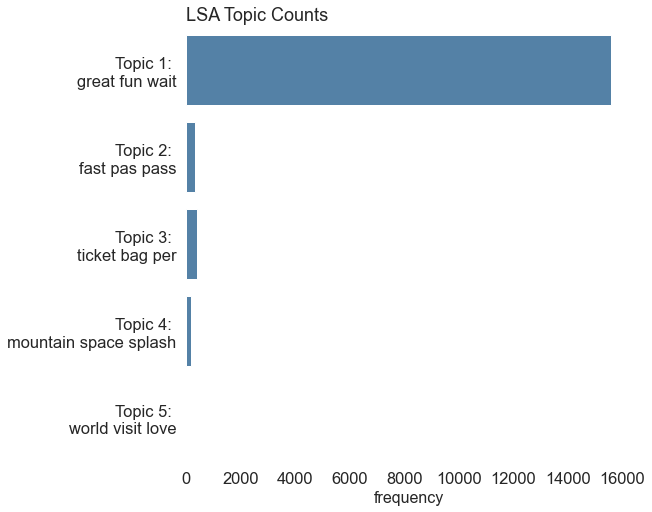

In [27]:
# Count vectorize the positive reviews
word_matrix = count_vectorizer.fit_transform(text_data)
# Return 5 topics with 10 words each
LSA(5, word_matrix, 10, count_vectorizer, 3)

#### Latent Dirichlet Allocation (LDA)

Topic 1:  world mountain great pirate much space like fun florida better
Topic 2:  cast member great halloween staff birthday special mickey party friendly
Topic 3:  great pas fast wait fun see visit like much really
Topic 4:  love always great fun earth family happiest visit experience every
Topic 5:  christmas holiday beautiful fun decoration magical spirit visited havent visit


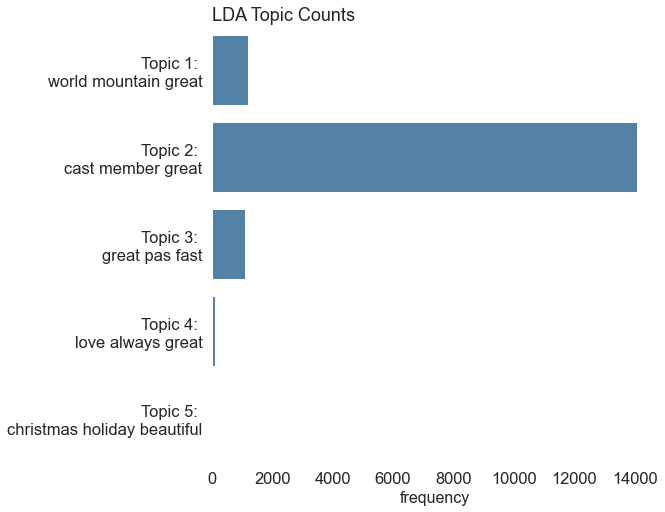

In [28]:
# Return 5 topics with 10 words each
LDA(5, word_matrix, 10, count_vectorizer, 3)

## Negative Reviews

In [29]:
text_data = neg_ca.clean

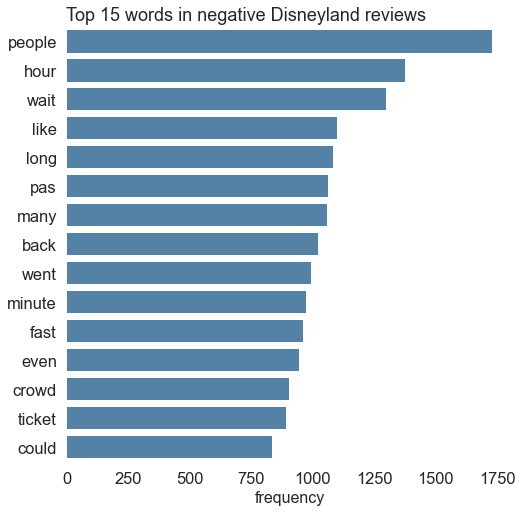

In [30]:
count_vectorizer = CountVectorizer(stop_words=stops)
words, word_values = get_top_k_words(15, count_vectorizer, text_data)
plot_top_words(15, 'negative Disneyland')

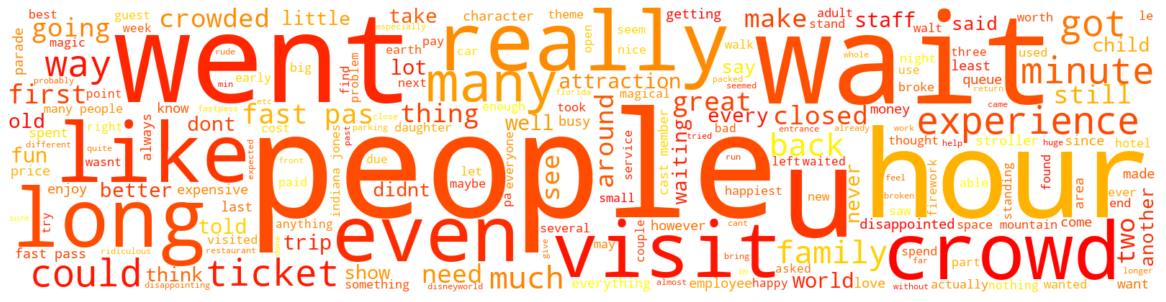

In [31]:
word_cloud(text_data, 'autumn')

In [32]:
#word_cloud(text_data, 'winter')

### Topic Modeling

#### Latent Semantic Analysis (LSA)

Topic 1:  people hour wait like long many pas back went even
Topic 2:  wait pas minute fast hour long 45 ticket use parking
Topic 3:  ticket told said could back member expedia phone fee person
Topic 4:  people rude ticket many need baby fast leave take front
Topic 5:  ticket price paid experience could pen long ink new hour


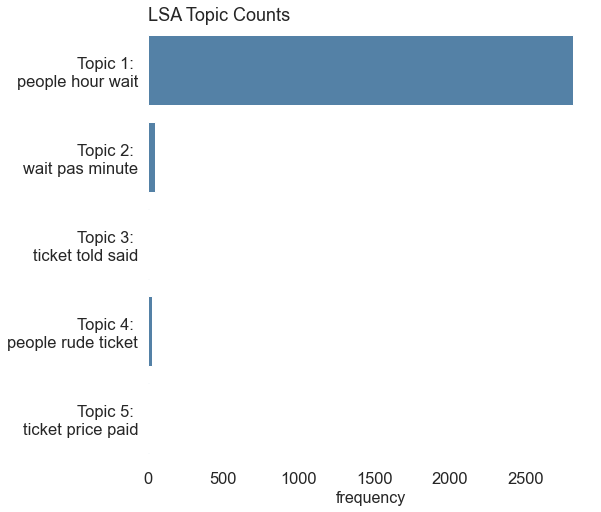

In [33]:
# Count vectorize the negative reviews
word_matrix = count_vectorizer.fit_transform(text_data)

# Return 5 topics with 10 words each
LSA(5, word_matrix, 10, count_vectorizer, 3)

#### Latent Dirichlet Allocation (LDA)

Topic 1:  dining spend terrace salad carthay tomatoeshungry fry circlechili tavernefried sour
Topic 2:  people hour wait pas ticket long fast minute money back
Topic 3:  februaryjanuary cliche vacsean going country iwent buy ityou arounld got
Topic 4:  wait poor lack save minute horrendously tomorrowland holding outrageous guest
Topic 5:  people hour like wait went many long back crowd world


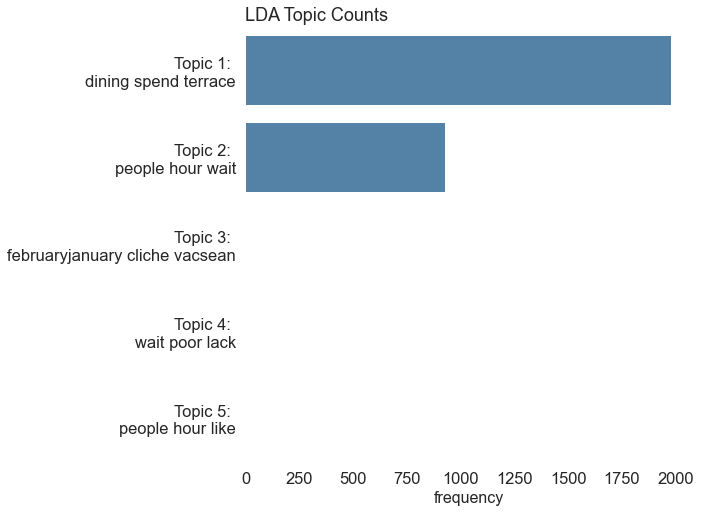

In [34]:
# Return 5 topics with 10 words each
LDA(5, word_matrix, 10, count_vectorizer, 3)

# Hong Kong Disneyland

In [35]:
# First, I will look at Disneyland in California
pos_hk = hk_reviews[hk_reviews.Sentiment=='positive'].reset_index()
neg_hk = hk_reviews[hk_reviews.Sentiment=='negative'].reset_index()

## Positive Reviews

In [36]:
text_data = pos_hk.clean

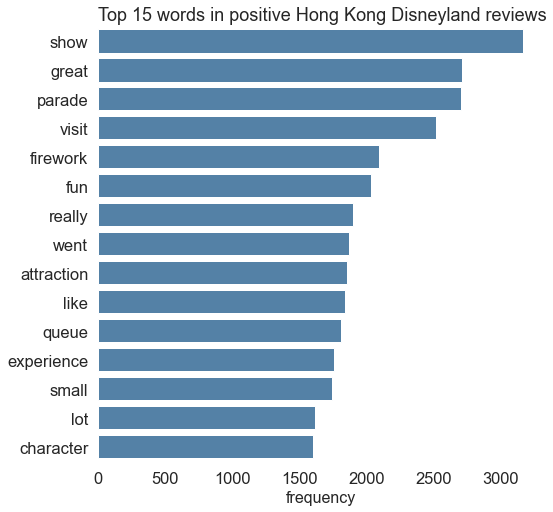

In [37]:
#count_vectorizer = CountVectorizer(stop_words=stops)
words, word_values = get_top_k_words(15, count_vectorizer, text_data)
plot_top_words(15, 'positive Hong Kong Disneyland')

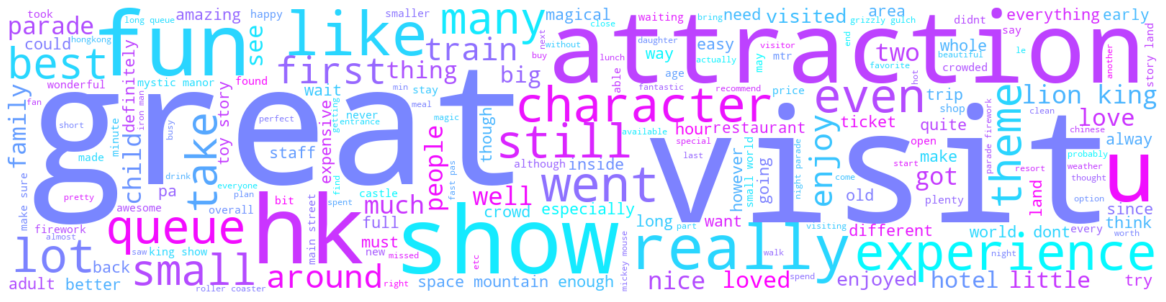

In [38]:
word_cloud(text_data, 'cool')

In [39]:
#word_cloud(text_data, 'summer')

In [40]:
# I am curious to see what guests are saying regarding the word small
neg_hk[neg_hk.Review_Text.str.contains('small')].Review_Text

0       Have been to Disney World, Disneyland Anaheim ...
3       We brought tickets before we left and got 2 da...
4       Around   60 per person and if you want to eat ...
5       First off I'm not a really big Disneyland fan....
9       This was my second trip here, the first been a...
                              ...                        
1860    I visited HK Disney quite a while ago (Jan 200...
1864    After going to disneyworld in orlando a few ye...
1865    What a waste of time and money. And to think I...
1866    Visited this place last Jan 23, 2006. Our all ...
1868    The park is small. Tiny small.They say one of ...
Name: Review_Text, Length: 697, dtype: object

### Topic Modeling

#### Latent Semantic Analysis (LSA)

Topic 1:  show great parade visit firework fun really went attraction like
Topic 2:  show parade king lion mickey firework must miss night amazing
Topic 3:  ticket queue take long station online train bay minute buy
Topic 4:  mountain land space grizzly toy story mystic attraction manor gulch
Topic 5:  great went really smaller staff old atmosphere think plenty busy


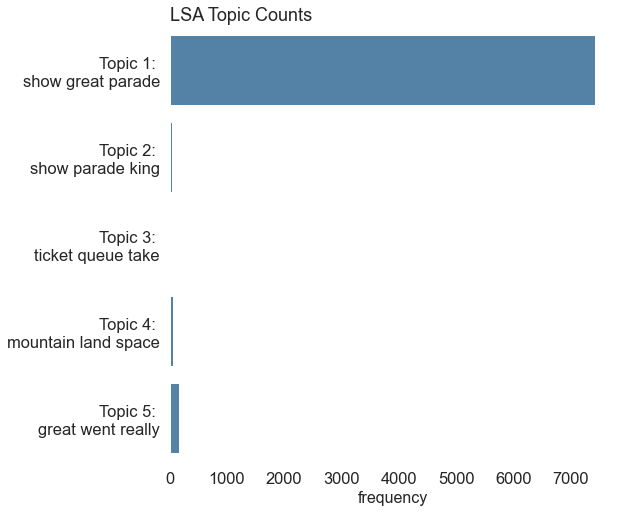

In [41]:
# Count vectorize the positive reviews
word_matrix = count_vectorizer.fit_transform(text_data)

# Return 5 topics with 10 words each
LSA(5, word_matrix, 10, count_vectorizer, 3)

#### Latent Dirichlet Allocation (LDA)

Topic 1:  ticket station pm cost meal hkd online bay take buy
Topic 2:  inside still water selfie many familyeven road obvious stick uaccessibility
Topic 3:  bring child water visit adult happiest earth fun really wear
Topic 4:  show great parade visit firework fun really went attraction like
Topic 5:  child best going enjoy aloud really photo entrance late veg


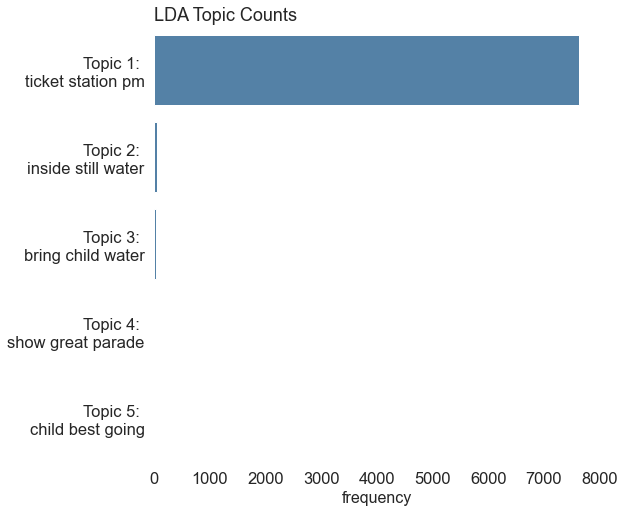

In [42]:
# Return 5 topics with 10 words each
LDA(5, word_matrix, 10, count_vectorizer, 3)

## Negative Reviews

In [43]:
text_data = neg_hk.clean

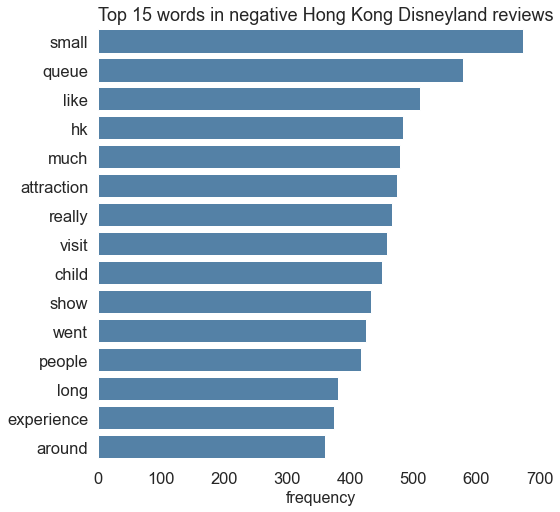

In [44]:
words, word_values = get_top_k_words(15, count_vectorizer, text_data)
plot_top_words(15, 'negative Hong Kong Disneyland')

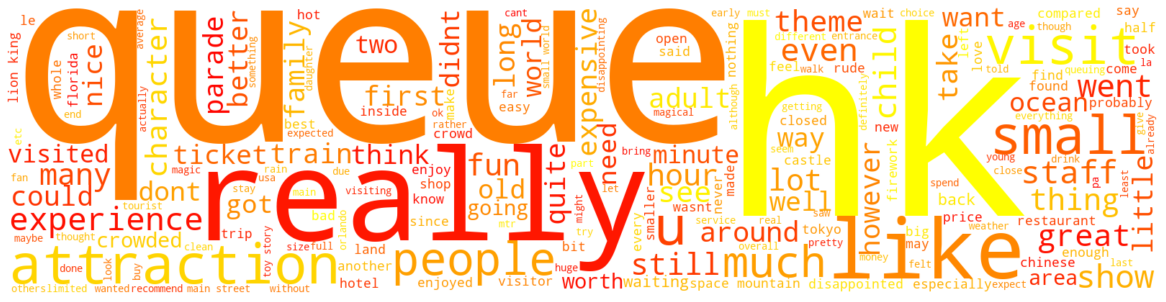

In [45]:
word_cloud(text_data, 'autumn')

In [46]:
#word_cloud(text_data, 'summer')

### Topic Modeling

#### Latent Semantic Analysis (LSA)

Topic 1:  small queue like much really attraction visit child hk went
Topic 2:  small world compared attraction many hk orlando adult fun usa
Topic 3:  show lion king firework mickey parade like attraction enjoyed really
Topic 4:  hk queue still better crowded like florida lot world dont
Topic 5:  around buy ticket shop photo character avoid take hk model


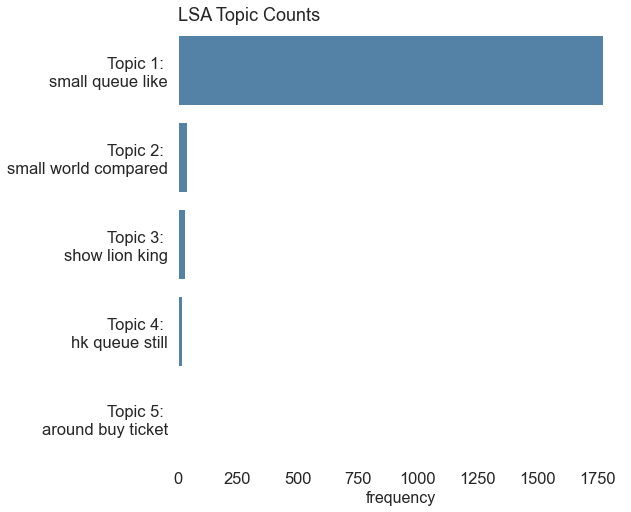

In [47]:
# Count vectorize the positive reviews
word_matrix = count_vectorizer.fit_transform(text_data)

# Return 5 topics with 10 words each
LSA(5, word_matrix, 10, count_vectorizer, 3)

#### Latent Dirichlet Allocation (LDA)

Topic 1:  small much like visit hk child queue really character attraction
Topic 2:  staff hk dont people small world many even experience like
Topic 3:  staff queue child experience people even hour take like photo
Topic 4:  daughter special mother part adult require fridge anger im start
Topic 5:  queue show small attraction really like went long much hk


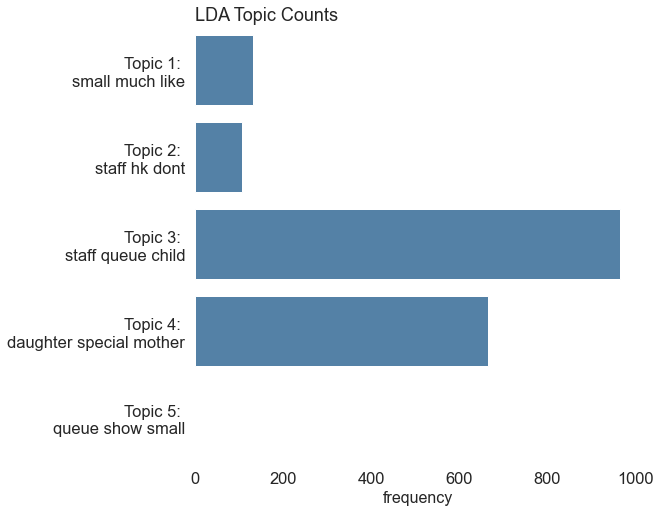

In [48]:
# Return 5 topics with 10 words each
LDA(5, word_matrix, 10, count_vectorizer, 3)

# Disneyland Paris

In [84]:
# First, I will look at Disneyland in California
pos_p = p_reviews[p_reviews.Sentiment=='positive'].reset_index()
neg_p = p_reviews[p_reviews.Sentiment=='negative'].reset_index()

## Positive Reviews

In [85]:
text_data = pos_p.clean

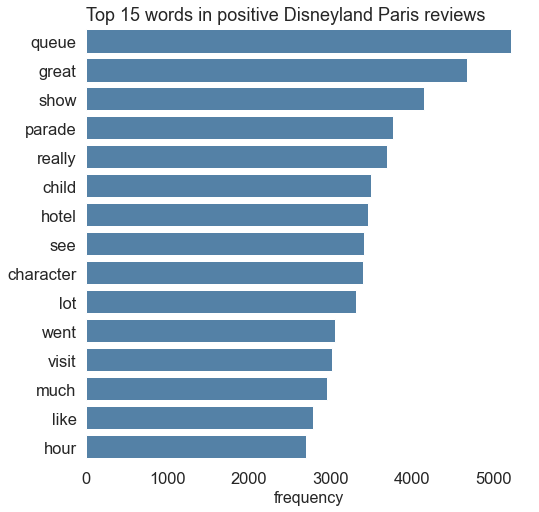

In [86]:
count_vectorizer = CountVectorizer(stop_words=stops)
words, word_values = get_top_k_words(15, count_vectorizer, text_data)
plot_top_words(15, 'positive Disneyland Paris')

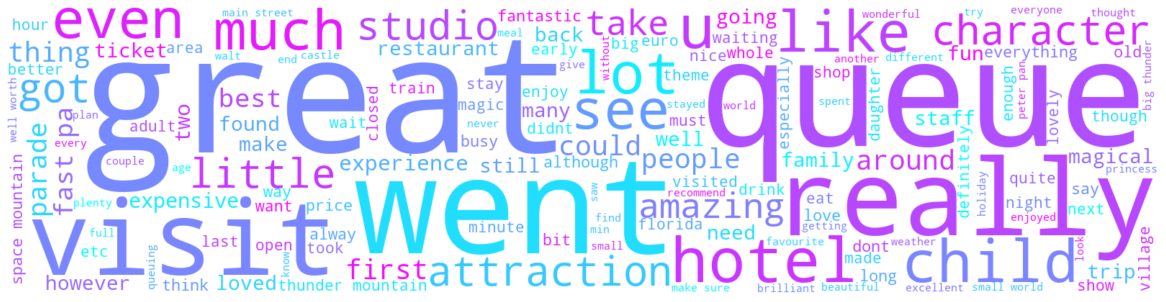

In [87]:
word_cloud(text_data, 'cool')

In [88]:
#word_cloud(text_data, 'autumn')

### Topic Modeling

#### Latent Semantic Analysis (LSA)

Topic 1:  queue great show parade really child character see hotel lot
Topic 2:  hotel stayed bus stay room euro cost price train recommend
Topic 3:  really love like great nice fun experience castle feel entertainment
Topic 4:  ticket fast pas studio mountain buy attraction use train take
Topic 5:  went queue got really fun great back loved long didnt


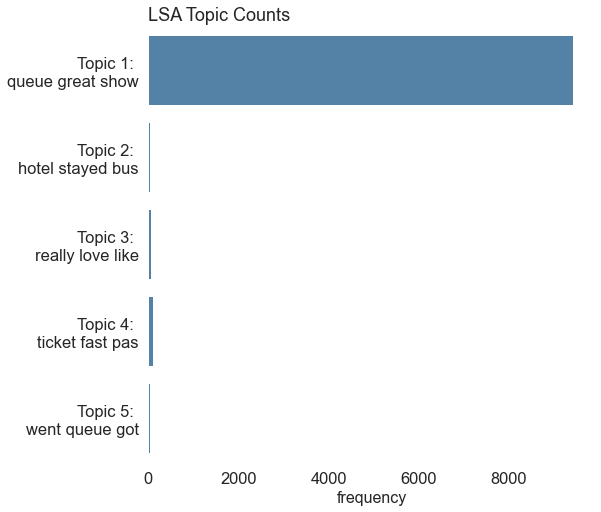

In [89]:
# Count vectorize the positive reviews
word_matrix = count_vectorizer.fit_transform(text_data)

# Return 5 topics with 10 words each
LSA(5, word_matrix, 10, count_vectorizer, 3)

#### Latent Dirichlet Allocation (LDA)

In [ ]:
# Return 4 topics with 10 words each
LDA(4, word_matrix, 10, count_vectorizer, 3)

## Negative Reviews

In [91]:
text_data = neg_p.clean

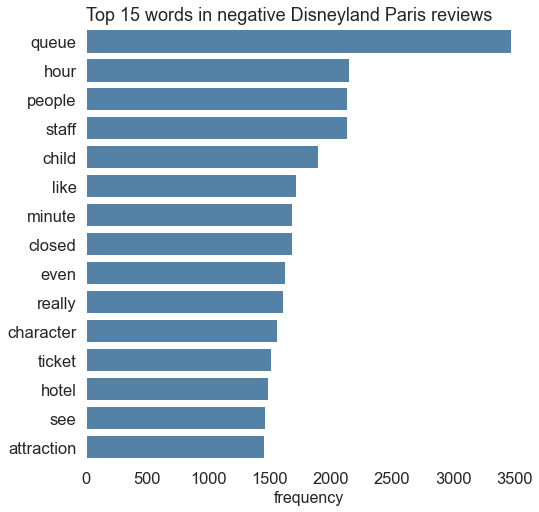

In [92]:
#count_vectorizer = CountVectorizer(stop_words=stops)
words, word_values = get_top_k_words(15, count_vectorizer, text_data)
plot_top_words(15, 'negative Disneyland Paris')

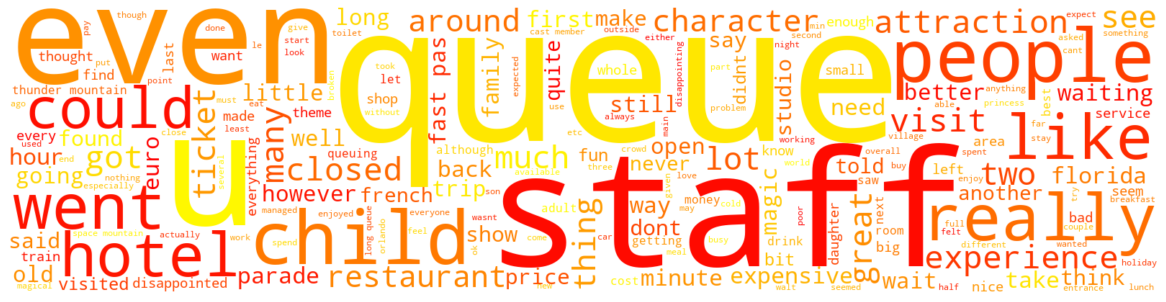

In [93]:
word_cloud(text_data, 'autumn')

### Topic Modeling

#### Latent Semantic Analysis (LSA)

Topic 1:  queue hour people staff child like closed minute really even
Topic 2:  queue long hour attraction minute fast child even min wait
Topic 3:  hotel room bus breakfast service even got staff told bag
Topic 4:  ticket fast online hotel buy refund euro purchase gate closed
Topic 5:  child euro wait minute buy expensive visit great adult per


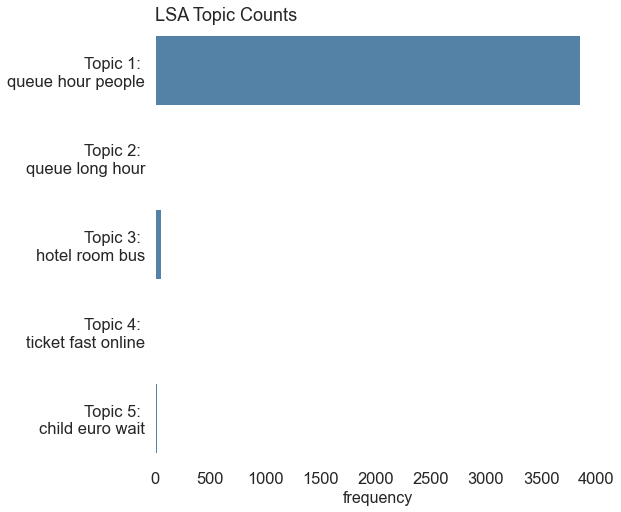

In [94]:
# Count vectorize the positive reviews
word_matrix = count_vectorizer.fit_transform(text_data)
# Return 5 topics with 10 words each
LSA(5, word_matrix, 10, count_vectorizer, 3)

#### Latent Dirichlet Allocation (LDA)

In [ ]:
# Return 3 topics with 10 words each
LDA(3, word_matrix, 10, count_vectorizer, 3)